In [1]:
import json
import pickle
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from collections import defaultdict

In [ ]:
# result_file_path = "../result/file_level_base/04-11_21-54_zero_prompt/final_results_phi4:14b.json"
# result_file_path = "../result/file_level_base/04-11_21-54_cot_prompt/final_results_phi4:14b.json"
# result_file_path = "../result/file_level_base/04-11_21-54_fs_prompt/final_results_phi4:14b.json"

# result_file_path = "../result/FT_file_result/04-18_08-37_zero_prompt/final_results_Phi4_FT_3ep_file.json"
# result_file_path = "../result/FT_file_result/04-18_08-37_cot_prompt/final_results_Phi4_FT_3ep_file.json"
# result_file_path = "../result/FT_file_result/04-18_08-37_fs_prompt/final_results_Phi4_FT_3ep_file.json"

# result_file_path = "../result/FT_file_explain/04-22_11-13_zero_prompt/final_results_FT_file_ep3_explain.json"
# result_file_path = "../result/FT_file_explain/04-22_11-13_cot_prompt/final_results_FT_file_ep3_explain.json"
# result_file_path = "../result/FT_file_explain/04-22_11-13_fs_prompt/final_results_FT_file_ep3_explain.json"

# result_file_path = "../result/func_level_base/04-11_17-55_zero_prompt/final_results_phi4:14b.json"
result_file_path = "../result/func_level_base/04-10_09-29_cot_prompt/final_results_phi4:14b.json"
# result_file_path = "../result/func_level_base/04-10_09-29_fs_prompt/final_results_phi4:14b.json"

# result_file_path = "../result/FT_func_result_ver2/04-19_22-49_zero_prompt/final_results_FT_func_ep3_v2.json"
# result_file_path = "../result/FT_func_result_ver2/04-19_22-49_cot_prompt/final_results_FT_func_ep3_v2.json"
# result_file_path = "../result/FT_func_result_ver2/04-19_22-49_fs_prompt/final_results_FT_func_ep3_v2.json"

# result_file_path = "../result/FT_func_explain/04-21_11-56_zero_prompt/final_results_FT_func_ep3_explain.json"
# result_file_path = "../result/FT_func_explain/04-21_11-56_cot_prompt/final_results_FT_func_ep3_explain.json"
# result_file_path = "../result/FT_func_explain/04-21_11-56_fs_prompt/final_results_FT_func_ep3_explain.json"

# result_file_path = "../result/FT_func_explain_ep1/04-23_04-56_zero_prompt/final_results_FT_func_ep1_explain.json"
# result_file_path = "../result/FT_func_explain_ep1/04-23_04-56_cot_prompt/final_results_FT_func_ep1_explain.json"
# result_file_path = "../result/FT_func_explain_ep1/04-23_04-56_fs_prompt/final_results_FT_func_ep1_explain.json"

# result_file_path = "../result/FT_func_explain/04-21_11-56_zero_prompt/final_results_FT_func_ep3_explain.json"
# result_file_path = "../result/FT_func_explain/04-21_11-56_cot_prompt/final_results_FT_func_ep3_explain.json"
# result_file_path = "../result/FT_func_explain/04-21_11-56_fs_prompt/final_results_FT_func_ep3_explain.json"

# result_file_path = "../result/FT_file_explain_simple/05-06_13-45_zero_prompt/final_results_FT_file_explain_simple.json"
# result_file_path = "../result/FT_file_explain_simple/05-06_13-45_cot_prompt/final_results_FT_file_explain_simple.json"
# result_file_path = "../result/FT_file_explain_simple/05-06_13-45_fs_prompt/final_results_FT_file_explain_simple.json"

# result_file_path = "../result/FT_file_explain_simple_v2/05-09_00-12_zero_prompt/final_results_FT_file_explain_simple.json"
# result_file_path = "../result/FT_file_explain_simple_v2/05-09_00-12_cot_prompt/final_results_FT_file_explain_simple.json"
# result_file_path = "../result/FT_file_explain_simple_v2/05-09_00-12_fs_prompt/final_results_FT_file_explain_simple.json"

# result_file_path = "../result/FT_func_explain_simple/05-06_20-19_zero_prompt/final_results_FT_func_explain_simple.json"
# result_file_path = "../result/FT_func_explain_simple/05-06_20-19_cot_prompt/final_results_FT_func_explain_simple.json"
# result_file_path = "../result/FT_func_explain_simple/05-06_20-19_fs_prompt/final_results_FT_func_explain_simple.json"

# result_file_path = "../result/FT_func_explain_simple_v2/05-09_15-43_zero_prompt/final_results_FT_func_explain_simple.json"
# result_file_path = "../result/FT_func_explain_simple_v2/05-09_15-43_cot_prompt/final_results_FT_func_explain_simple.json"
# result_file_path = "../result/FT_func_explain_simple_v2/05-09_15-43_fs_prompt/final_results_FT_func_explain_simple.json"

# Load the JSON file
with open(result_file_path, 'r') as file:
    results = json.load(file)

print(len(results))

494


# Result Analysis

In [3]:
from random import randint 
print(json.dumps(results[randint(0, len(results))], indent=4))

{
    "index": 457,
    "file_change_id": "62729208306204",
    "lang": "Python",
    "vuln_type": "non_vuln",
    "result": {
        "reasoning": "The code is a Flask application that implements OAuth2 and OpenID Connect for user authentication. It includes routes for signing in, handling callbacks, and signing out. The application uses JWTs to handle user information after successful authentication.\n\n1. **Overall Structure**: The app has three main routes: `/`, `/sign-in`, and `/sign-out`. The `/` route displays the user's sign-in status. The `/sign-in` initiates an OAuth2 authorization request, while `/sign-in/callback` handles the response from the identity provider (IDP). The `/sign-out` clears the session.\n\n2. **User Input Handling & Data Flow**: \n   - User input is received via query parameters (`code`, `state`) and cookies (`python-flask-csrf`).\n   - The application uses a CSRF token stored in a cookie to protect against Cross-Site Request Forgery attacks during the OAut

In [4]:
chosen_cwes = ['79', '89', '434', '352']
langs = ['ALL', 'PHP', 'JavaScript', 'Java', 'TypeScript', 'Ruby', 'Python']

def judge_cwe(cwe):
    for chosen_cwe in chosen_cwes:
        if chosen_cwe in cwe:
            return 'CWE-'+ chosen_cwe
    return 'None'

true_label = []
pred_label = []
for result in results:
      true = result['vuln_type']

      if true == 'non_vuln': true = 'None'

      if(result['result'].get('cwe_id') != None):
        pred = judge_cwe(result['result']['cwe_id'])
        true_label.append(true)
        pred_label.append(pred)
print(len(true_label), len(pred_label))

484 484


In [5]:
print(np.unique(true_label, return_counts=True))
print(np.unique(pred_label, return_counts=True))

(array(['CWE-352', 'CWE-434', 'CWE-79', 'CWE-89', 'None'], dtype='<U7'), array([ 28,  12, 122,  80, 242]))
(array(['CWE-352', 'CWE-434', 'CWE-79', 'CWE-89', 'None'], dtype='<U7'), array([ 19,  16,  75, 108, 266]))


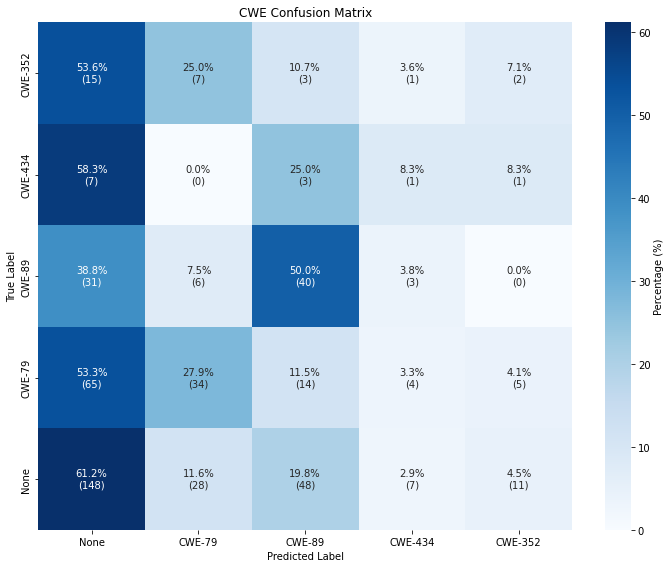

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix

cwe_classes = ['None', 'CWE-79', 'CWE-89', 'CWE-434', 'CWE-352']
language_classes = ['PHP', 'JavaScript', 'Java', 'TypeScript', 'Ruby', 'Python']

# Compute confusion matrix and normalize
cwe_cm = confusion_matrix(true_label, pred_label, labels=cwe_classes)
row_sums = cwe_cm.sum(axis=1, keepdims=True)
cwe_cm_percent = np.divide(cwe_cm, row_sums, where=row_sums!=0) * 100

# Flip the matrix and labels for desired axis orientation
cwe_cm_flipped = cwe_cm[::-1]
cwe_cm_percent_flipped = cwe_cm_percent[::-1]
flipped_labels = cwe_classes[::-1]

# Create annotations with both percentage and raw count
annot = np.empty_like(cwe_cm_percent_flipped, dtype=object)
for i in range(cwe_cm_flipped.shape[0]):
    for j in range(cwe_cm_flipped.shape[1]):
        percent = f"{cwe_cm_percent_flipped[i, j]:.1f}%"
        count = f"({cwe_cm_flipped[i, j]})"
        annot[i, j] = f"{percent}\n{count}"

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cwe_cm_percent_flipped,
    annot=annot,
    fmt="",
    cmap="Blues",
    xticklabels=cwe_classes,
    yticklabels=flipped_labels,
    cbar_kws={'label': 'Percentage (%)'}
)
plt.title("CWE Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [7]:
cwe_cm

array([[148,  28,  48,   7,  11],
       [ 65,  34,  14,   4,   5],
       [ 31,   6,  40,   3,   0],
       [  7,   0,   3,   1,   1],
       [ 15,   7,   3,   1,   2]])

In [8]:
# Calculate metrics for each CWE class
cwe_table = []
for i, cwe in enumerate(cwe_classes):
    TP = cwe_cm[i, i]
    FN = cwe_cm[i, :].sum() - TP
    FP = cwe_cm[:, i].sum() - TP
    TN = cwe_cm.sum() - (TP + FP + FN)
    
    # Total actual positives (TP + FN)
    total_actual_positives = TP + FN
    # Total predicted positives (TP + FP)
    total_predicted_positives = TP + FP
    
    # Calculate ratios
    FNR = FN / (FN + TP)  # False Negative Rate (FNR)
    FPR = FP / (FP + TN)  # False Positive Rate (FPR)
    
    Acc = (TP + TN) / cwe_cm.sum()

    if cwe == 'CWE-79':
        print("CWE-79 TP:", TP)
        print("CWE-79 FN:", FP)
        print("CWE-79 total_predicted_positives", total_predicted_positives)


    Precision = TP / total_predicted_positives if total_predicted_positives != 0 else 0
    Recall = TP / total_actual_positives if total_actual_positives != 0 else 0
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0
    
    cwe_table.append([cwe, FN, FP, FNR, FPR, Acc, Precision, Recall, F1])

# Print CWE metrics table
print("\nCWE-Class Metrics:")
print(f"{'CWE-Class':<12} {'FNR%':<6} {'FPR%':<6} {'Acc':<6} {'Precision':<9} {'Recall':<6} {'F1':<6}") 
for row in cwe_table:
    print(f"{row[0]:<12} {row[3]:<6.2f} {row[4]:<6.2f} {row[5]:<6.2f} {row[6]:<9.2f} {row[7]:<6.2f} {row[8]:<6.2f}")

CWE-79 TP: 34
CWE-79 FN: 41
CWE-79 total_predicted_positives 75

CWE-Class Metrics:
CWE-Class    FNR%   FPR%   Acc    Precision Recall F1    
None         0.39   0.49   0.56   0.56      0.61   0.58  
CWE-79       0.72   0.11   0.73   0.45      0.28   0.35  
CWE-89       0.50   0.17   0.78   0.37      0.50   0.43  
CWE-434      0.92   0.03   0.95   0.06      0.08   0.07  
CWE-352      0.93   0.04   0.91   0.11      0.07   0.09  


In [9]:
np.unique(true_label, return_counts=True)

(array(['CWE-352', 'CWE-434', 'CWE-79', 'CWE-89', 'None'], dtype='<U7'),
 array([ 28,  12, 122,  80, 242]))

In [10]:
np.unique(pred_label, return_counts=True)

(array(['CWE-352', 'CWE-434', 'CWE-79', 'CWE-89', 'None'], dtype='<U7'),
 array([ 19,  16,  75, 108, 266]))

In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def calculate__metrics(true_label, pred_label):
  """
  Calculate weighted and macro classification metrics for imbalanced multi-class data.
  
  Args:
    true_label (array-like): Ground truth labels.
    pred_label (array-like): Predicted labels.
    
  Returns:
    dict: Metrics including Accuracy, Precision, Recall, F1-score, FNR, and FPR (both weighted and macro).
  """
  cwe_classes = np.unique(true_label)
  cm = confusion_matrix(true_label, pred_label, labels=cwe_classes)
  support = cm.sum(axis=1)  # Number of samples per class

  # True positives per class
  tp = np.diag(cm)
  # False positives: predicted as class i but actually another class
  fp = cm.sum(axis=0) - tp
  # False negatives: actually class i but predicted as another
  fn = cm.sum(axis=1) - tp
  # True negatives: all others
  tn = cm.sum() - (tp + fp + fn)

  # Per-class FNR and FPR
  fnr = fn / (fn + tp + 1e-12)  # Avoid division by zero
  fpr = fp / (fp + tn + 1e-12)

  # Weighted (support-based) averages
  weighted_fnr = np.average(fnr, weights=support)
  weighted_fpr = np.average(fpr, weights=support)

  # Macro (unweighted) averages
  macro_fnr = np.mean(fnr)
  macro_fpr = np.mean(fpr)

  # Metrics from sklearn
  acc = accuracy_score(true_label, pred_label)
  precision = precision_score(true_label, pred_label, average='weighted', zero_division=0)
  recall = recall_score(true_label, pred_label, average='weighted', zero_division=0)
  f1 = f1_score(true_label, pred_label, average='weighted', zero_division=0)
  macro_f1 = f1_score(true_label, pred_label, average='macro', zero_division=0)

  return {
    "Weighted Accuracy": acc,
    "Weighted Precision": precision,
    "Weighted Recall": recall,
    "Weighted F1-score": f1,
    "Weighted FNR": weighted_fnr,
    "Weighted FPR": weighted_fpr,
    "Macro F1-score": macro_f1,
    "Macro FNR": macro_fnr,
    "Macro FPR": macro_fpr
  }

metrics = calculate__metrics(true_label, pred_label)
    
# Print results
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Weighted Accuracy: 0.4649
Weighted Precision: 0.4613
Weighted Recall: 0.4649
Weighted F1-score: 0.4554
Weighted FNR: 0.5351
Weighted FPR: 0.3031
Macro F1-score: 0.3020
Macro FNR: 0.6910
Macro FPR: 0.1676
